<a href="https://colab.research.google.com/github/entmike/disco-diffusion-1/blob/main/View%20Job.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖼️ Simplified Disco Diffusion (Batch Viewer)

[![Discord](https://badgen.net/badge/icon/discord?icon=discord&label)](https://discord.gg/FqsE83fT)
[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/entmike/disco-diffusion-1)
![Terminal](https://badgen.net/badge/icon/terminal?icon=terminal&label)
[![Issues](https://img.shields.io/github/issues/entmike/disco-diffusion-1)](https://github.com/entmike/disco-diffusion-1/issues)
![Stars](https://img.shields.io/github/stars/entmike/disco-diffusion-1)
![Commits](https://img.shields.io/github/commit-activity/w/entmike/disco-diffusion-1)

**Expand this section for details.**

Special thanks to Zippy#1111 on Discord (https://gist.github.com/aredden) for image grid ninja work!

In [1]:
import subprocess
use_google_drive = True #@param {type:"boolean"}
dbpath = "/content/gdrive/MyDrive/disco-diffusion-1/disco.db" #@param {type:"string"}
if use_google_drive == True:
  import os
  from google.colab import drive
  if os.path.isdir('/content/gdrive') == False:
    print(f'📁 Mounting Google Drive.  Please accept any confirmation screens.')
    drive.mount('/content/gdrive/')
  else:
    print(f'📁 Google Drive already mounted.')
  content_root = '/content/gdrive/MyDrive'
else:
  content_root = '.'

📁 Mounting Google Drive.  Please accept any confirmation screens.
Mounted at /content/gdrive/


In [2]:
import sqlite3
import io
import numpy as np
from IPython.display import Image, display
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image as PILImg
from typing import List
import cv2

def fetchImages(sql = None):
    dbcon = sqlite3.connect(dbpath)
    cursor = dbcon.cursor()
    cursor.execute(sql)
    records = cursor.fetchall()
    dbcon.close()
    images = []
    for row in records:
        blob_data = row[0]
        # nparr = np.fromstring(blob_data, np.uint8)
        images.append([np.array(PILImg.open(io.BytesIO(blob_data))), row[1]])
    return images

def image_grid(images: List[np.ndarray], ncols: int, scale=0.5):
    """
    Creates a grid of images with 'ncols' number of image columns, images must all be the same shape.
    """
    assert len(images) >= ncols, "Must have more images than columns"
    nrows = math.ceil(len(images) / ncols)
    images_size = images[0][0].shape[:2]
    grid_img = np.zeros((nrows * images_size[0], ncols * images_size[1], 3), dtype=np.uint8)
    for i, img in enumerate(images):
        # image, name = img
        img = cv2.putText(
            img=img[0].astype(np.uint8),
            text=img[1].split("/")[-1],
            org=(40, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2,
            color=(255,255,255),
            thickness=4,
            lineType=cv2.LINE_8,
        )
        r = int(i / ncols)
        c = i % ncols
        grid_img[r * images_size[0]:(r + 1) * images_size[0], c * images_size[1]:(c + 1) * images_size[1]] = img
    if scale != 1:
        grid_img = cv2.resize(grid_img, (0,0), fx=scale, fy=scale,interpolation=cv2.INTER_LANCZOS4)
    return grid_img

def displayGrid(image):
    fig = plt.figure(dpi=300)
    plot = fig.add_subplot(111)
    plot.axis('off')
    plot.imshow(image)
    plot.set_xlim(0,image.shape[1])
    plot.set_ylim(image.shape[0],0)
    plot.set_alpha(1)
    plot.set_clip_on(True)
    plot.figure.canvas.draw()

# List Batch Jobs and Display Batch in a Grid

In [30]:
import pandas as pd
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(dbpath)
df = pd.read_sql_query(f"""
SELECT session_uuid, timestamp, count(image_path) AS image_count FROM (
  SELECT session_uuid, 
  strftime('%d/%m/%Y %H:%M:%S', datetime(jobs.timestamp, 'unixepoch')) AS timestamp,
  image_path FROM jobs INNER JOIN images on images.job_uuid = jobs.uuid ORDER BY timestamp DESC
)
GROUP BY session_uuid, timestamp
ORDER BY timestamp DESC
""", con)
con.close()

# Verify that result of SQL query is stored in the dataframe
display(df.head(5))

,session_uuid,timestamp,image_count
0,6d5b9269-bebc-498c-83ab-7ceaca5d4a37,06/05/2022 19:49:19,1
1,55cd08f3-ca80-4b2f-99b5-c1366abc0607,06/05/2022 19:28:47,1
2,55cd08f3-ca80-4b2f-99b5-c1366abc0607,06/05/2022 19:26:59,1
3,3d423637-ebc3-4c3c-bd22-b3ab8ebaa873,06/05/2022 18:58:52,1
4,3d423637-ebc3-4c3c-bd22-b3ab8ebaa873,06/05/2022 18:46:05,1


SELECT images.image, images.image_path FROM jobs INNER JOIN images ON images.job_uuid = jobs.uuid WHERE jobs.session_uuid='09d779e6-3368-4236-a6b9-68790212c142'
4 images found.


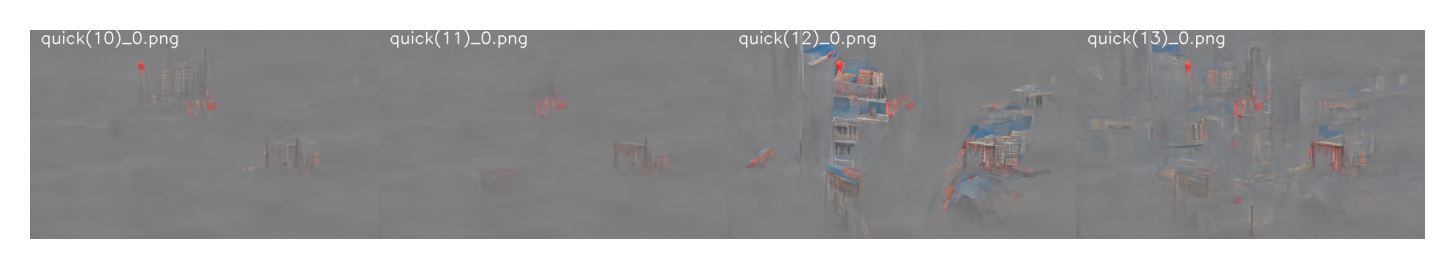

In [31]:
session_id = '09d779e6-3368-4236-a6b9-68790212c142'
sql = f"SELECT images.image, images.image_path FROM jobs INNER JOIN images ON images.job_uuid = jobs.uuid WHERE jobs.session_uuid='{session_id}'"
print(sql)
images = fetchImages(sql = sql)
if len(images) > 0:
  print(f'{len(images)} images found.')
  max_cols = 5
  cols = max_cols
  if len(images)<max_cols:
    cols = len(images)
    
  grid = image_grid(images, cols)
  displayGrid(grid)
else:
  print("No images found for that session.")